In [67]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [68]:
# Download Bitcoin data using yfinance (last 5 years)
btc_data = yf.download('BTC-USD', start='2018-01-01', end='2025-01-01')

# Select the closing price
btc_data = btc_data[['Close']]
btc_data = btc_data.dropna()  # Remove missing values

# Check the first 5 rows of the data
btc_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,BTC-USD
Date,
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000
2018-01-04,15599.200195
2018-01-05,17429.500000


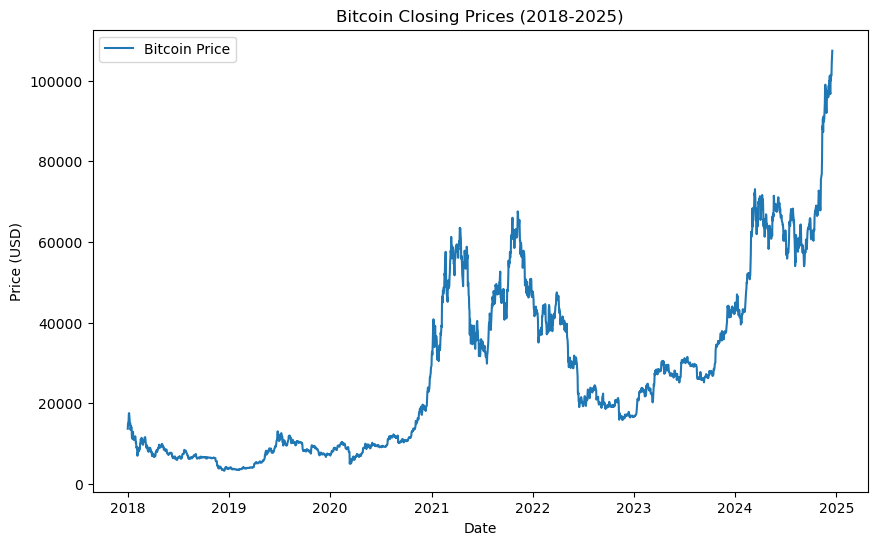

In [69]:
# Visualize Bitcoin closing prices
plt.figure(figsize=(10, 6))
plt.plot(btc_data['Close'], label='Bitcoin Price')
plt.title('Bitcoin Closing Prices (2018-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [70]:
# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(btc_data['Close'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% training, 20% testing
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

train_data.shape, test_data.shape

((2034, 1), (509, 1))

In [71]:
# Prepare the input (X) and output (y) for LSTM
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  # Last 60 days
        y.append(data[i, 0])  # Price on that day
    return np.array(X), np.array(y)

time_step = 60  # We will use the last 60 days for prediction
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape the data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1974, 60, 1), (1974,), (449, 60, 1), (449,))

In [72]:
# Build the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # We will output a single prediction value

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
62/62 [==============================] - 2s 34ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 2/50
62/62 [==============================] - 2s 37ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 3/50
62/62 [==============================] - 2s 32ms/step - loss: 9.6376e-04 - val_loss: 0.0013
Epoch 4/50
62/62 [==============================] - 2s 28ms/step - loss: 9.2745e-04 - val_loss: 0.0024
Epoch 5/50
62/62 [==============================] - 2s 30ms/step - loss: 8.3145e-04 - val_loss: 0.0012
Epoch 6/50
62/62 [==============================] - 2s 32ms/step - loss: 7.5792e-04 - val_loss: 0.0023
Epoch 7/50
62/62 [==============================] - 2s 34ms/step - loss: 7.8219e-04 - val_loss: 0.0026
Epoch 8/50
62/62 [==============================] - 2s 34ms/step - loss: 7.0539e-04 - val_loss: 0.0016
Epoch 9/50
62/62 [==============================] - 2s 31ms/step - loss: 7.0364e-04 - val_loss: 9.9461e-04
Epoch 10/50
62/62 [==============================] - 2s 39ms/step - loss: 5.8

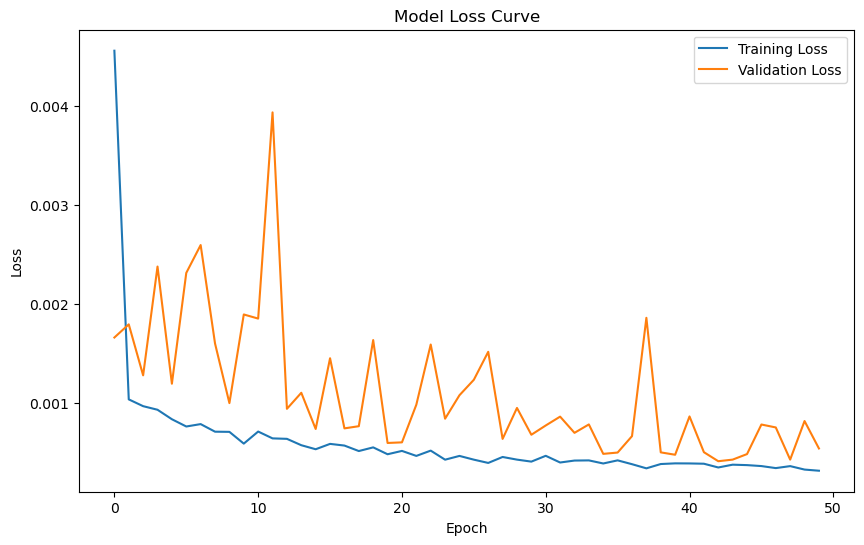

In [73]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Visualize the loss during the training process
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

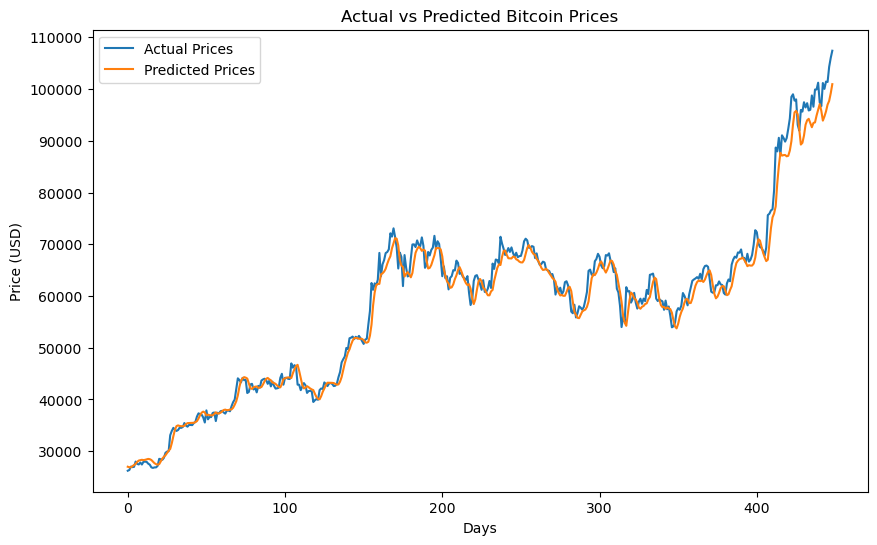

In [74]:
# Make predictions using the test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Reverse scale the predictions

# Visualize the real vs predicted prices
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.title('Actual vs Predicted Bitcoin Prices')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

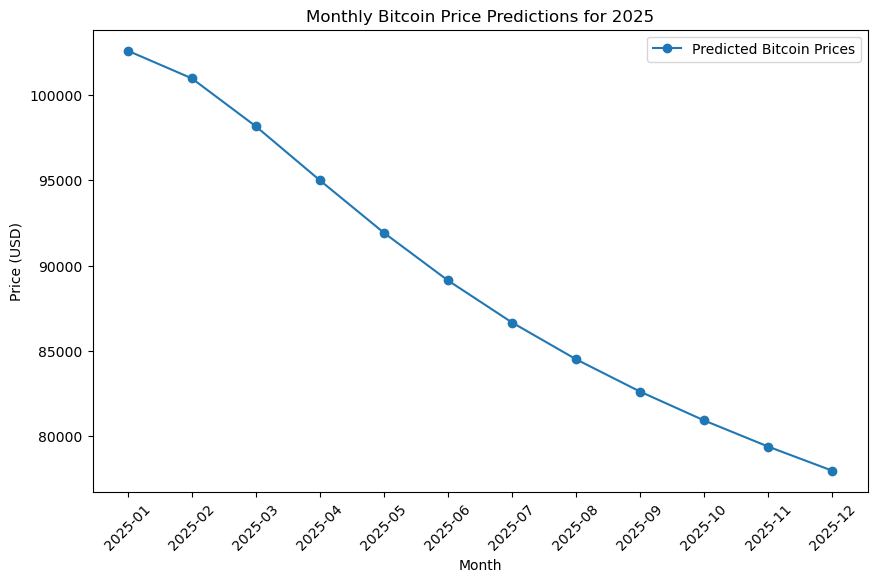

      Month  Predicted Price (USD)
0   2025-01          102587.398438
1   2025-02          100968.281250
2   2025-03           98157.093750
3   2025-04           94994.070312
4   2025-05           91920.367188
5   2025-06           89127.296875
6   2025-07           86664.257812
7   2025-08           84509.898438
8   2025-09           82614.953125
9   2025-10           80925.523438
10  2025-11           79393.921875
11  2025-12           77982.367188


In [75]:
# Make predictions for the year 2025
# Take the last 60 days of data
future_data = scaled_data[-time_step:]  # Take the last 60 days
future_data = future_data.reshape(1, time_step, 1)

future_predictions = []
for i in range(12):  # Make predictions for 12 months
    pred = model.predict(future_data)
    future_predictions.append(pred[0][0])  # Store the prediction
    # Update future_data with the new prediction
    pred_reshaped = np.array(pred).reshape(1, 1, 1)
    future_data = np.append(future_data[:, 1:, :], pred_reshaped, axis=1)

# Reverse scale the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Visualize the monthly predictions for 2025
months = ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07', '2025-08', '2025-09', '2025-10', '2025-11', '2025-12']
plt.figure(figsize=(10, 6))
plt.plot(months, future_predictions, marker='o', label='Predicted Bitcoin Prices')
plt.title('Monthly Bitcoin Price Predictions for 2025')
plt.xlabel('Month')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Show the monthly predictions in a table
future_df = pd.DataFrame({'Month': months, 'Predicted Price (USD)': future_predictions.flatten()})
print(future_df)